In [ ]:
!pip install langchain==0.3.14
!pip install langchain-openai==0.3.0
!pip install langchain-community==0.3.14
!pip install langgraph==0.2.64
!pip install rich

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.9/326.9 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.11
    Uninstalling langsmith-0.3.11:
      Successfully uninstalled langsmith-0.3.11
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.19
    Uninstalling langchain-0.3.19:
      Successfully uninstalled langchain-0.3.19
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.8 MB/s eta 0:00:00


In [ ]:
from getpass import getpass
OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


In [ ]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key: ··········


In [ ]:
import os
os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

In [ ]:
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import operator
from typing import  Annotated, List, Optional, Literal

# defines structure for each section in the report
class Section(BaseModel):
    name: str = Field(
        description="Name for a particular section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )
    research: bool = Field(
        description="Whether to perform web search for this section of the report."
    )
    content: str = Field(
        description="The content for this section."
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="All the Sections of the overall report.",
    )

# defines structure for queries generated for deep research
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query for web search.")

class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of web search queries.",
    )

# consists of input topic and output report generated
class ReportStateInput(TypedDict):
    topic: str # Report topic

class ReportStateOutput(TypedDict):
    final_report: str # Final report

# overall agent state which will be passed and updated in nodes in the graph
class ReportState(TypedDict):
    topic: str # Report topic
    sections: list[Section] # List of report sections
    completed_sections: Annotated[list, operator.add] # Send() API
    report_sections_from_research: str # completed sections to write final sections
    final_report: str # Final report

# defines the key structure for sections written using the agent
class SectionState(TypedDict):
    section: Section # Report section
    search_queries: list[SearchQuery] # List of search queries
    source_str: str # String of formatted source content from web search
    report_sections_from_research: str # completed sections to write final sections
    completed_sections: list[Section] # Final key in outer state for Send() API

class SectionOutputState(TypedDict):
    completed_sections: list[Section]

In [ ]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
import asyncio
from dataclasses import asdict, dataclass

# just to handle objects created from LLM reponses
@dataclass
class SearchQuery:
    search_query: str

    def to_dict(self) -> Dict[str, Any]:
        return asdict(self)

tavily_search = TavilySearchAPIWrapper()

async def run_search_queries(
    search_queries: List[Union[str, SearchQuery]],
    num_results: int = 5,
    include_raw_content: bool = False
) -> List[Dict]:
    search_tasks = []
    for query in search_queries:
        # Handle both string and SearchQuery objects
        # Just in case LLM fails to generate queries as:
        # class SearchQuery(BaseModel):
        #     search_query: str
        query_str = query.search_query if isinstance(query, SearchQuery) else str(query) # text query
        try:
            # get results from tavily async (in parallel) for each search query
            search_tasks.append(
                tavily_search.raw_results_async(
                    query=query_str,
                    max_results=num_results,
                    search_depth='advanced',
                    include_answer=False,
                    include_raw_content=include_raw_content
                )
            )
        except Exception as e:
            print(f"Error creating search task for query '{query_str}': {e}")
            continue
    # Execute all searches concurrently and await results
    try:
        if not search_tasks:
            return []
        search_docs = await asyncio.gather(*search_tasks, return_exceptions=True)
        # Filter out any exceptions from the results
        valid_results = [
            doc for doc in search_docs
            if not isinstance(doc, Exception)
        ]
        return valid_results
    except Exception as e:
        print(f"Error during search queries: {e}")
        return []

In [ ]:
import tiktoken
from typing import List, Dict, Union, Any

def format_search_query_results(
    search_response: Union[Dict[str, Any], List[Any]],
    max_tokens: int = 2000,
    include_raw_content: bool = False
) -> str:
    encoding = tiktoken.encoding_for_model("gpt-4")
    sources_list = []

    # Handle different response formats if search results is a dict
    if isinstance(search_response, dict):
        if 'results' in search_response:
            sources_list.extend(search_response['results'])
        else:
            sources_list.append(search_response)
    # if search results is a list
    elif isinstance(search_response, list):
        for response in search_response:
            if isinstance(response, dict):
                if 'results' in response:
                    sources_list.extend(response['results'])
                else:
                    sources_list.append(response)
            elif isinstance(response, list):
                sources_list.extend(response)

    if not sources_list:
        return "No search results found."

    # Deduplicate by URL and keep unique sources (website urls)
    unique_sources = {}
    for source in sources_list:
        if isinstance(source, dict) and 'url' in source:
            if source['url'] not in unique_sources:
                unique_sources[source['url']] = source

    # Format output
    formatted_text = "Content from web search:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source.get('title', 'Untitled')}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source.get('content', 'No content available')}\n===\n"

        if include_raw_content:
            # truncate raw webpage content to a certain number of tokens to prevent exceeding LLM max token window
            raw_content = source.get("raw_content", "")
            if raw_content:
                tokens = encoding.encode(raw_content)
                truncated_tokens = tokens[:max_tokens]
                truncated_content = encoding.decode(truncated_tokens)
                formatted_text += f"Raw Content: {truncated_content}\n\n"


    return formatted_text.strip()

In [ ]:
docs = await run_search_queries(['langgraph'], include_raw_content=True)
output = format_search_query_results(docs, max_tokens=500,
   include_raw_content=True)
print(output)

Content from web search:

Source langchain-ai/langgraph: Build resilient language agents as graphs.:
===
URL: https://github.com/langchain-ai/langgraph
===
Most relevant content from source: GitHub - langchain-ai/langgraph: Build resilient language agents as graphs. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Let's build a tool-calling ReAct-style agent that uses a search tool! The simplest way to create a tool-calling agent in LangGraph is to use create_react_agent: Define the tools for the agent to use Define the tools for the agent to use This means that after tools is called, agent node is called next. workflow.add_edge("tools", 'agent') Normal edge: after the tools are invoked, the graph should always return to the agent to decide what to do next LangGraph adds the input message to the internal state, then passes the state to the entrypoint node, "agent".
===
Raw Content: GitHub - langchain-ai/la

In [ ]:
# Structure Guideline
DEFAULT_REPORT_STRUCTURE = """The report structure should focus on breaking-down the user-provided topic
                              and building a comprehensive report in markdown using the following format:


                              1. Introduction (no web search needed)
                                    - Brief overview of the topic area


                              2. Main Body Sections:
                                    - Each section should focus on a sub-topic of the user-provided topic
                                    - Include any key concepts and definitions
                                    - Provide real-world examples or case studies where applicable


                              3. Conclusion (no web search needed)
                                    - Aim for 1 structural element (either a list of table) that distills the main body sections
                                    - Provide a concise summary of the report


                              When generating the final response in markdown, if there are special characters in the text,
                              such as the dollar symbol, ensure they are escaped properly for correct rendering e.g $25.5 should become \$25.5
                          """

In [ ]:
REPORT_PLAN_QUERY_GENERATOR_PROMPT = """You are an expert technical report writer, helping to plan a report.

The report will be focused on the following topic:
{topic}

The report structure will follow these guidelines:
{report_organization}

Your goal is to generate {number_of_queries} search queries that will help gather comprehensive information for planning the report sections.

The query should:
1. Be related to the topic
2. Help satisfy the requirements specified in the report organization

Make the query specific enough to find high-quality, relevant sources while covering the depth and breadth needed for the report structure.
"""

In [ ]:
REPORT_PLAN_SECTION_GENERATOR_PROMPT = """You are an expert technical report writer, helping to plan a report.

Your goal is to generate the outline of the sections of the report.

The overall topic of the report is:
{topic}

The report should follow this organizational structure:
{report_organization}

You should reflect on this additional context information from web searches to plan the main sections of the report:
{search_context}

Now, generate the sections of the report. Each section should have the following fields:
- Name - Name for this section of the report.
- Description - Brief overview of the main topics and concepts to be covered in this section.
- Research - Whether to perform web search for this section of the report or not.
- Content - The content of the section, which you will leave blank for now.

Consider which sections require web search.
For example, introduction and conclusion will not require research because they will distill information from other parts of the report.
"""

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

async def generate_report_plan(state: ReportState):
    """Generate the overall plan for building the report"""
    topic = state["topic"]
    print('--- Generating Report Plan ---')

    report_structure = DEFAULT_REPORT_STRUCTURE
    number_of_queries = 8

    structured_llm = llm.with_structured_output(Queries)

    system_instructions_query = REPORT_PLAN_QUERY_GENERATOR_PROMPT.format(
        topic=topic,
        report_organization=report_structure,
        number_of_queries=number_of_queries
    )

    try:
        # Generate queries
        results = structured_llm.invoke([
            SystemMessage(content=system_instructions_query),
            HumanMessage(content='Generate search queries that will help with planning the sections of the report.')
        ])
        # Convert SearchQuery objects to strings
        query_list = [
            query.search_query if isinstance(query, SearchQuery) else str(query)
            for query in results.queries
        ]
        # Search web and ensure we wait for results
        search_docs = await run_search_queries(
            query_list,
            num_results=5,
            include_raw_content=False
        )
        if not search_docs:
            print("Warning: No search results returned")
            search_context = "No search results available."
        else:
            search_context = format_search_query_results(
                search_docs,
                include_raw_content=False
            )
        # Generate sections
        system_instructions_sections = REPORT_PLAN_SECTION_GENERATOR_PROMPT.format(
            topic=topic,
            report_organization=report_structure,
            search_context=search_context
        )
        structured_llm = llm.with_structured_output(Sections)
        report_sections = structured_llm.invoke([
            SystemMessage(content=system_instructions_sections),
            HumanMessage(content="Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. Each section must have: name, description, plan, research, and content fields.")
        ])

        print('--- Generating Report Plan Completed ---')
        return {"sections": report_sections.sections}

    except Exception as e:
        print(f"Error in generate_report_plan: {e}")
        return {"sections": []}

In [ ]:
REPORT_SECTION_QUERY_GENERATOR_PROMPT = """Your goal is to generate targeted web search queries that will gather comprehensive information for writing a technical report section.

Topic for this section:
{section_topic}

When generating {number_of_queries} search queries, ensure that they:
1. Cover different aspects of the topic (e.g., core features, real-world applications, technical architecture)
2. Include specific technical terms related to the topic
3. Target recent information by including year markers where relevant (e.g., "2024")
4. Look for comparisons or differentiators from similar technologies/approaches
5. Search for both official documentation and practical implementation examples

Your queries should be:
- Specific enough to avoid generic results
- Technical enough to capture detailed implementation information
- Diverse enough to cover all aspects of the section plan
- Focused on authoritative sources (documentation, technical blogs, academic papers)"""


In [ ]:
def generate_queries(state: SectionState):
    """ Generate search queries for a specific report section """

    # Get state
    section = state["section"]
    print('--- Generating Search Queries for Section: '+ section.name +' ---')
    # Get configuration
    number_of_queries = 5
    # Generate queries
    structured_llm = llm.with_structured_output(Queries)
    # Format system instructions
    system_instructions = REPORT_SECTION_QUERY_GENERATOR_PROMPT.format(section_topic=section.description,                                                                       number_of_queries=number_of_queries)
    # Generate queries
    user_instruction = "Generate search queries on the provided topic."
    search_queries = structured_llm.invoke([SystemMessage(content=system_instructions),
                                     HumanMessage(content=user_instruction)])

    print('--- Generating Search Queries for Section: '+ section.name +' Completed ---')
    return {"search_queries": search_queries.queries}

In [ ]:
async def search_web(state: SectionState):
    """ Search the web for each query, then return a list of raw sources and a formatted string of sources."""

    # Get state
    search_queries = state["search_queries"]
    print('--- Searching Web for Queries ---')
    # Web search
    query_list = [query.search_query for query in search_queries]
    search_docs = await run_search_queries(search_queries, num_results=6, include_raw_content=True)
    # Deduplicate and format sources
    search_context = format_search_query_results(search_docs, max_tokens=4000, include_raw_content=True)

    print('--- Searching Web for Queries Completed ---')
    return {"source_str": search_context}

In [ ]:
SECTION_WRITER_PROMPT = """You are an expert technical writer crafting one specific section of a technical report.

Title for the section:
{section_title}

Topic for this section:
{section_topic}

Guidelines for writing:

1. Technical Accuracy:
- Include specific version numbers
- Reference concrete metrics/benchmarks
- Cite official documentation
- Use technical terminology precisely

2. Length and Style:
- Strict 150-200 word limit
- No marketing language
- Technical focus
- Write in simple, clear language do not use complex words unnecessarily
- Start with your most important insight in **bold**
- Use short paragraphs (2-3 sentences max)

3. Structure:
- Use ## for section title (Markdown format)
- Only use ONE structural element IF it helps clarify your point:
  * Either a focused table comparing 2-3 key items (using Markdown table syntax)
  * Or a short list (3-5 items) using proper Markdown list syntax:
    - Use `*` or `-` for unordered lists
    - Use `1.` for ordered lists
    - Ensure proper indentation and spacing
- End with ### Sources that references the below source material formatted as:
  * List each source with title, date, and URL
  * Format: `- Title : URL`

3. Writing Approach:
- Include at least one specific example or case study if available
- Use concrete details over general statements
- Make every word count
- No preamble prior to creating the section content
- Focus on your single most important point

4. Use this source material obtained from web searches to help write the section:
{context}

5. Quality Checks:
- Format should be Markdown
- Exactly 150-200 words (excluding title and sources)
- Careful use of only ONE structural element (table or bullet list) and only if it helps clarify your point
- One specific example / case study if available
- Starts with bold insight
- No preamble prior to creating the section content
- Sources cited at end
- If there are special characters in the text, such as the dollar symbol,
  ensure they are escaped properly for correct rendering e.g $25.5 should become \$25.5
"""

In [ ]:
def write_section(state: SectionState):
    """ Write a section of the report """

    # Get state
    section = state["section"]
    source_str = state["source_str"]
    print('--- Writing Section : '+ section.name +' ---')
    # Format system instructions
    system_instructions = SECTION_WRITER_PROMPT.format(section_title=section.name, section_topic=section.description, context=source_str)
    # Generate section
    user_instruction = "Generate a report section based on the provided sources."
    section_content = llm.invoke([SystemMessage(content=system_instructions),
                                  HumanMessage(content=user_instruction)])
    # Write content to the section object
    section.content = section_content.content

    print('--- Writing Section : '+ section.name +' Completed ---')
    # Write the updated section to completed sections
    return {"completed_sections": [section]}

In [ ]:
!mmdc --version


11.4.2


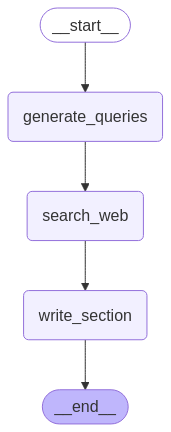

In [ ]:
from langgraph.graph import StateGraph, START, END

# Add nodes and edges
section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)
section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")
section_builder.add_edge("write_section", END)
section_builder_subagent = section_builder.compile()

# Display the graph
from IPython.display import display, Image
Image(section_builder_subagent.get_graph().draw_mermaid_png())


In [ ]:
from langgraph.constants import Send


def parallelize_section_writing(state: ReportState):
    """ This is the "map" step when we kick off web research for some sections of the report in parallel and then write the section"""


    # Kick off section writing in parallel via Send() API for any sections that require research
    return [
        Send("section_builder_with_web_search", # name of the subagent node
             {"section": s})
            for s in state["sections"]
              if s.research
    ]

In [ ]:
def format_sections(sections: list[Section]) -> str:
    """ Format a list of report sections into a single text string """
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
{'='*60}
Section {idx}: {section.name}
{'='*60}
Description:
{section.description}
Requires Research:
{section.research}

Content:
{section.content if section.content else '[Not yet written]'}

"""
    return formatted_str

def format_completed_sections(state: ReportState):
    """ Gather completed sections from research and format them as context for writing the final sections """

    print('--- Formatting Completed Sections ---')
    # List of completed sections
    completed_sections = state["completed_sections"]
    # Format completed section to str to use as context for final sections
    completed_report_sections = format_sections(completed_sections)

    print('--- Formatting Completed Sections is Done ---')
    return {"report_sections_from_research": completed_report_sections}

In [ ]:
FINAL_SECTION_WRITER_PROMPT = """You are an expert technical writer crafting a section that synthesizes information from the rest of the report.

Title for the section:
{section_title}

Topic for this section:
{section_topic}

Available report content of already completed sections:
{context}

1. Section-Specific Approach:

For Introduction:
- Use # for report title (Markdown format)
- 50-100 word limit
- Write in simple and clear language
- Focus on the core motivation for the report in 1-2 paragraphs
- Use a clear narrative arc to introduce the report
- Include NO structural elements (no lists or tables)
- No sources section needed

For Conclusion/Summary:
- Use ## for section title (Markdown format)
- 100-150 word limit
- For comparative reports:
    * Must include a focused comparison table using Markdown table syntax
    * Table should distill insights from the report
    * Keep table entries clear and concise
- For non-comparative reports:
    * Only use ONE structural element IF it helps distill the points made in the report:
    * Either a focused table comparing items present in the report (using Markdown table syntax)
    * Or a short list using proper Markdown list syntax:
      - Use `*` or `-` for unordered lists
      - Use `1.` for ordered lists
      - Ensure proper indentation and spacing
- End with specific next steps or implications
- No sources section needed

3. Writing Approach:
- Use concrete details over general statements
- Make every word count
- Focus on your single most important point

4. Quality Checks:
- For introduction: 50-100 word limit, # for report title, no structural elements, no sources section
- For conclusion: 100-150 word limit, ## for section title, only ONE structural element at most, no sources section
- Markdown format
- Do not include word count or any preamble in your response
- If there are special characters in the text, such as the dollar symbol,
  ensure they are escaped properly for correct rendering e.g $25.5 should become \$25.5"""

In [ ]:
def write_final_sections(state: SectionState):
    """ Write the final sections of the report, which do not require web search and use the completed sections as context"""

    # Get state
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]

    print('--- Writing Final Section: '+ section.name + ' ---')
    # Format system instructions
    system_instructions = FINAL_SECTION_WRITER_PROMPT.format(section_title=section.name,
                                                             section_topic=section.description,
                                                             context=completed_report_sections)

    # Generate section
    user_instruction = "Craft a report section based on the provided sources."
    section_content = llm.invoke([SystemMessage(content=system_instructions),
                                  HumanMessage(content=user_instruction)])

    # Write content to section
    section.content = section_content.content

    print('--- Writing Final Section: '+ section.name + ' Completed ---')
    # Write the updated section to completed sections
    return {"completed_sections": [section]}

In [ ]:
from langgraph.constants import Send

def parallelize_final_section_writing(state: ReportState):
    """ Write any final sections using the Send API to parallelize the process """

    # Kick off section writing in parallel via Send() API for any sections that do not require research
    return [
        Send("write_final_sections",
             {"section": s, "report_sections_from_research": state["report_sections_from_research"]})
                 for s in state["sections"]
                    if not s.research
    ]

In [ ]:
def compile_final_report(state: ReportState):
    """ Compile the final report """

    # Get sections
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}

    print('--- Compiling Final Report ---')
    # Update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])
    # Escape unescaped $ symbols to display properly in Markdown
    formatted_sections = all_sections.replace("\\$", "TEMP_PLACEHOLDER")  # Temporarily mark already escaped $
    formatted_sections = formatted_sections.replace("$", "\\$")  # Escape all $
    formatted_sections = formatted_sections.replace("TEMP_PLACEHOLDER", "\\$")  # Restore originally escaped $

    # Now escaped_sections contains the properly escaped Markdown text
    print('--- Compiling Final Report Done ---')
    return {"final_report": formatted_sections}

--- Writing Section : NVIDIA's Business Model and Revenue Growth Completed ---


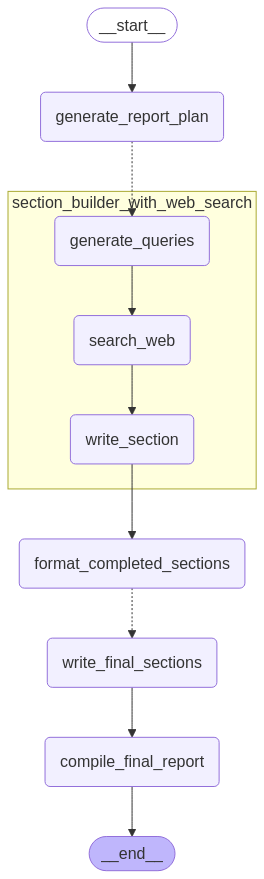

In [ ]:
builder = StateGraph(ReportState, input=ReportStateInput, output=ReportStateOutput)

builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("section_builder_with_web_search", section_builder_subagent)
builder.add_node("format_completed_sections", format_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)

builder.add_edge(START, "generate_report_plan")
builder.add_conditional_edges("generate_report_plan",
                              parallelize_section_writing,
                              ["section_builder_with_web_search"])
builder.add_edge("section_builder_with_web_search", "format_completed_sections")
builder.add_conditional_edges("format_completed_sections",
                              parallelize_final_section_writing,
                              ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

reporter_agent = builder.compile()
# view agent structure
display(Image(reporter_agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
from IPython.display import display
from rich.console import Console
from rich.markdown import Markdown as RichMarkdown
import asyncio  # Import asyncio

async def call_planner_agent(agent, prompt, config={"recursion_limit": 50}, verbose=False):
    events = agent.astream(
        {'topic': prompt},
        config,
        stream_mode="values",
    )

    async for event in events:
        for k, v in event.items():
            if verbose:
                if k != "__end__":
                    display(RichMarkdown(repr(k) + ' -> ' + repr(v)))
            if k == 'final_report':
                print('=' * 50)
                print('Final Report:')
                md = RichMarkdown(v)
                display(md)
        # Introduce a delay of 20 seconds after each event processing
        await asyncio.sleep(30)  # Adjust the delay as needed

In [ ]:
topic = "Detailed report on how is NVIDIA winning the game against its competitors"
await call_planner_agent(agent=reporter_agent,
                         prompt=topic)

--- Generating Report Plan ---
--- Generating Report Plan Completed ---
--- Generating Search Queries for Section: NVIDIA's Technological Innovations ------ Generating Search Queries for Section: Market Dominance in AI Chips ---

--- Generating Search Queries for Section: Strategic Partnerships and Collaborations ---
--- Generating Search Queries for Section: Competitive Analysis: NVIDIA vs. Rivals ---
--- Generating Search Queries for Section: Future Prospects and Challenges ---
--- Generating Search Queries for Section: NVIDIA's Technological Innovations Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section: Competitive Analysis: NVIDIA vs. Rivals Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section: Future Prospects and Challenges Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section: Market Dominance in AI Chips Completed ---
--- Searching Web for Queries ---
--- Generating 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                  Introduction                                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

NVIDIA stands at the forefront of the technology sector, particularly in the GPU market, where it has established a
commanding presence. With a remarkable 65% market share in the AI chip industry, NVIDIA's innovations, such as the 
CUDA platform and the Grace Hopper Superchip, have positioned it as a leader in high-performance computing and     
artificial intelligence. However, the competitive landscape is evolving, with rivals like AMD and Intel            
intensifying their efforts to capture market segments. This report delves into NVIDIA's technological advancements,
market dominance, strategic partnerships, competitive analysis, and future prospects, providing a comprehensive    
overview of its current standing and the challenges it faces.                                                      


                                        NVIDIA's Technological Innovations                                         

NVIDIA's advancements in GPU technology, particularly with CUDA and the Grace Hopper Superchip, solidify its       
leadership in the AI and high-performance computing sectors.                                                       

The CUDA (Compute Unified Device Architecture) platform, first released in 2007, has evolved significantly, with   
version 12.4 launched in March 2024. CUDA enables developers to leverage the parallel processing capabilities of   
NVIDIA GPUs, which are essential for AI workloads. For instance, benchmarks show that NVIDIA GPUs can complete     
training epochs for neural networks up to 28.4 times faster than traditional CPUs (source: Girolino).              

The recent introduction of the Grace Hopper Superchip combines the Hopper GPU and Grace CPU, featuring a           
high-bandwidth NVLink-C2C interconnect that delivers up to 900 GB/s of bandwidth. This architecture allows for     
efficient memory access and processing, crucial for large-scale AI models (source: NVIDIA). The Grace Hopper       
Superchip is designed to handle complex tasks, such as training large language models, with performance metrics    
indicating it can achieve up to 1,979 TFLOPS in FP16 operations (source: Hyperstack).                              

                                                      Sources                                                      

 • CUDA: New Features and Beyond | NVIDIA GTC 2024 - YouTube: https://www.youtube.com/watch?v=pC0SIzZGFSc          
 • NVIDIA Grace Hopper Superchip Architecture and Performance Optimizations for Deep Learning Applications | GTC 24
   2024 | NVIDIA: https://www.nvidia.com/en-us/on-demand/session/gtc24-s61159/                                     
 • GPU Applications in AI and Data Science: NVIDIA's Impact:                                                       
   https://www.girolino.com/gpu-revolution-in-ai-and-data-science/                                                 
 • NVIDIA Unveils AI & Supercomputing Advances at SC 2024:                                                         
   https://www.techrepublic.com/article/nvidia-ai-supercomputing-2024/                                             


                                           Market Dominance in AI Chips                                            

NVIDIA commands a staggering 65% market share in the AI chip industry, significantly outpacing competitors like    
Intel and AMD. In 2023, NVIDIA's revenue from data center AI chips reached $26 billion, driven by the demand for   
its H100 and A100 GPUs, which are now industry standards for AI workloads. The overall market for data-center AI   
chips was valued at $17.7 billion, with Intel

In [ ]:
topic = "Detailed report on the world will be affected after Trump's re-election in 2024"
await call_planner_agent(agent=reporter_agent,
                         prompt=topic)

--- Generating Report Plan ---
--- Generating Report Plan Completed ---
--- Generating Search Queries for Section: Political Landscape ------ Generating Search Queries for Section: Economic Implications ---
--- Generating Search Queries for Section: Immigration Policies ---

--- Generating Search Queries for Section: Social Dynamics and Human Rights ---
--- Generating Search Queries for Section: Environmental Policies ---
--- Generating Search Queries for Section: Environmental Policies Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section: Immigration Policies Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section: Social Dynamics and Human Rights Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section: Economic Implications Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section: Political Landscape Completed ---
--- Searching Web for Queries ---


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                  Introduction                                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

This report examines the potential implications of Donald Trump's re-election in 2024, highlighting its            
far-reaching effects on global politics, economics, immigration policies, social dynamics, and environmental       
strategies. As the U.S. navigates a complex international landscape, Trump's return to power could lead to         
significant shifts in foreign relations, economic stability, and social equity. The analysis aims to provide a     
comprehensive understanding of how these changes may reshape not only the United States but also its role on the   
world stage, influencing alliances, trade, and human rights initiatives.                                           


                                                Political Landscape                                                

Trump's re-election could significantly destabilize international relations, particularly through a shift in U.S.  
foreign policy that prioritizes unilateralism and transactional diplomacy.                                         

Key implications include:                                                                                          

 • NATO and European Security: Trump has previously threatened to withdraw U.S. support from NATO unless European  
   allies meet defense spending targets. This could lead to a "Dormant NATO" scenario, where the U.S. reduces its  
   military presence in Europe, compelling European nations to increase their own defense expenditures             
   significantly (potentially to 3% of GDP) to maintain security (Source: Carnegie Endowment).                     
 • Ukraine Policy: Trump has indicated a willingness to pressure Ukraine into unfavorable peace negotiations with  
   Russia, potentially reducing U.S. military aid and altering the balance of power in Eastern Europe (Source:     
   Carnegie Endowment, NPR).                                                                                       
 • Trade Relations: A return to aggressive tariff policies, including potential tariffs of up to 60% on Chinese    
   imports, could ignite trade wars that disrupt global markets and strain U.S.-EU relations (Source: NPR, Carnegie
   Endowment).                                                                                                     
 • Global Governance: Trump's skepticism towards multilateral organizations may lead to a partial withdrawal from  
   international agreements, allowing China to expand its influence in global governance (Source: Chatham House).  

                                                      Sources                                                      

 • Title: Getting Europe Ready for a Second Trump Administration : URL:                                            
   https://carnegieendowment.org/emissary/2024/11/europe-trump-second-term-ukraine-nato-migration?lang=en          
 • Title: Trump's aggressive foreign policy decisions have shaken the globe : URL:                                 
   https://www.npr.org/2025/02/13/nx-s1-5287002/trumps-aggressive-foreign-policy-decisions-have-shaken-the-globe   
 • Title: Trump's 'America First' foreign policy will accelerate China's push for global leadership : URL:         
   https://www.chathamhouse.org/2024/11/trumps-america-first-foreign-policy-will-accelerate-chinas-push-global-lead
   ership                                                                                                          


                                               Economic Implications                                               

Trump's tariffs are projected to significantl